<a href="https://colab.research.google.com/github/helebkat/ocular-disease-ml/blob/main/Eye_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eye Disease Classification

In this project, we will develop a machine learning model for binary classification to distinguish between normal and cataract-affected eyes. Our approach leverages a Convolutional Neural Network (CNN) architecture, utilizing a pretrained Keras model as the backbone. This pretrained model is fine-tuned using our dataset to adapt it for the specific task of classifying eye conditions.

We utilized Keras's flow_from_dataframe functionality to streamline the preprocessing pipeline, enabling the generation of augmented and scaled images directly from a structured dataframe. Furthermore, we applied various preprocessing parameters to adjust and enhance the images, ensuring the input data is optimized for training. By combining the feature extraction power of CNNs with transfer learning and robust preprocessing techniques, this project aims to deliver an accurate and efficient solution for binary classification of eye conditions.

In [1]:
# dependencies
!pip install -q kaggle tensorflow

# installation
import numpy as np
import pandas as pd
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial Data Preperation

Lets set up our file paths and take a look at some of the the data we have right now:


In [3]:
image_dir = 'drive/MyDrive/ocular-dataset/preprocessed_images'
csv_dir = 'drive/MyDrive/ocular-dataset/full_df.csv'

df = pd.read_csv(csv_dir)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [4]:
df = pd.read_csv(csv_dir)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


I found that the categories "N D G C A H M O" causes issues because there would be some values were positive for both normal and disease eyes, but there would be no specification on which eye the disease was on. The issue with this is that the files and diagnosis are orientation specific and the row of data contains both eyes information. If we use the categories exclusively, we run into the problem later on where pulling specific eye orientation data is impossible as it is lost in the encoded categories.
Therefore I chose to exclude those categories for this project.


In [5]:
df2 = df.iloc[:, 1:7]
df2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


# Data Preperation for Cataract Eyes

Lets start with extracting the Left-Diagnosis for the 'cataract' keyword. We will also do the same for the Right-Diagnosis.

In [6]:
# Left diagnosis with 'cataract' disease

df2[df2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [7]:
# lets put the left cararact data into its own dataframe and see the number of rows it has

df2_left = df2[df2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df2_left))

294


In [8]:
# Right diagnosis with 'cataract' disease

df2[df2['Right-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
20,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract
93,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract
160,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract
186,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract
309,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract


In [9]:
# lets put the right cararact data into its own dataframe and see the number of rows it has

df2_right = df2[df2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df2_right))

278


In [10]:
# combine the left and right cataract data toghether

df_cat_all = pd.concat([df2_left['Left-Fundus'], df2_right['Right-Fundus']], ignore_index=True)
df_cat_all.head()

,0
0,0_left.jpg
1,103_left.jpg
2,119_left.jpg
3,254_left.jpg
4,294_left.jpg


In [11]:
# lets see how much data for cataract eyes we are working with

len(df_cat_all)

572

This number will be important later when we compare this to the amount of data for normal eyes.

# Image Preperation for Cataract

Lets begin by seeing a random image to see what we are working with

(512, 512, 3)
2120_right.jpg


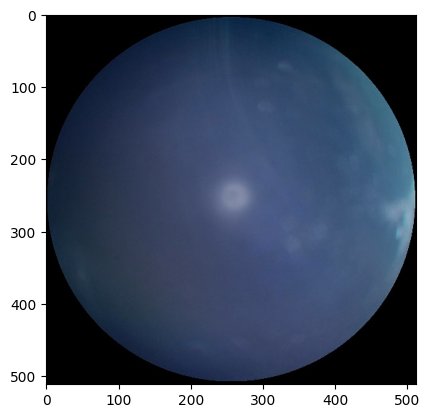

In [12]:
# lets view a random example image

img = df_cat_all[342]
image = cv2.imread(os.path.join(image_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

To better understand what cataracts look like, we will create a comparative grid showcasing images from our cataract dataset. By visualizing these examples side by side, we can observe common patterns and features associated with cataract-affected eyes. Additionally, the images will be converted to a realistic RGB color palette, enhancing their visual clarity and making them more representative of real-world conditions.

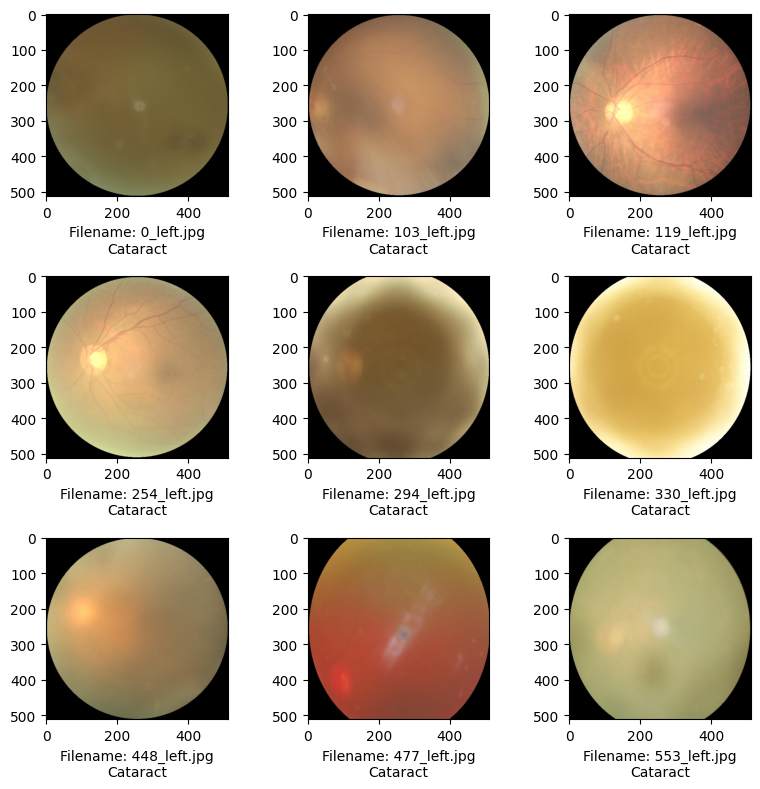

In [13]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_all[i]
    image = cv2.imread(os.path.join(image_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_all[i]))

plt.tight_layout()

# Data Preperation for Normal Eyes

Next, we will gather a set of normal eye images for our analysis. While we previously reviewed the count of available normal images, it is important to revisit this to ensure completeness. Since we are working with data from both eyes, we must account for discrepancies where some encoded columns lack data for one eye, potentially leaving gaps in the full picture. To address this, we will rely on the labeling in the 'keywords' column as the primary source of truth, as it provides a comprehensive perspective by considering both eyes together.

In [14]:
# create a new dataframe for normal eyes in the left eye and print out the number of rows

df_left_norm = df2[df2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [15]:
# create a new dataframe for normal eyes in the right eye and print out the number of rows

df_rt_norm = df2[df2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


In [16]:
# combine dataframes into one

df_norm_all = pd.concat([df_left_norm['Left-Fundus'], df_rt_norm['Right-Fundus']], ignore_index=True)
df_norm_all


,0
0,1_left.jpg
1,8_left.jpg
2,9_left.jpg
3,14_left.jpg
4,15_left.jpg
...,...
5585,4642_right.jpg
5586,4644_right.jpg
5587,4660_right.jpg
5588,4671_right.jpg


In total, we have over 5,000 images classified as 'normal,' including both left and right eye images. This is significantly more than the 572 images available in the 'cataract' category. To maintain balance in our dataset and ensure fair model training, we will randomly select an equal number of 572 'normal' images to match the size of the cataract dataset.

In [17]:
# pick 572 normal eye images to match the number of cataract images we pulled

df_norm_random = df_norm_all.sample(n = 572)
df_norm_random.head()

,0
3841,3091_right.jpg
4970,2854_right.jpg
671,2792_left.jpg
2945,460_right.jpg
1652,1311_left.jpg


In [18]:
# reset the index

df_norm_random = df_norm_random.reset_index(drop=True)
df_norm_random

,0
0,3091_right.jpg
1,2854_right.jpg
2,2792_left.jpg
3,460_right.jpg
4,1311_left.jpg
...,...
567,2716_left.jpg
568,2956_right.jpg
569,4130_left.jpg
570,4076_left.jpg


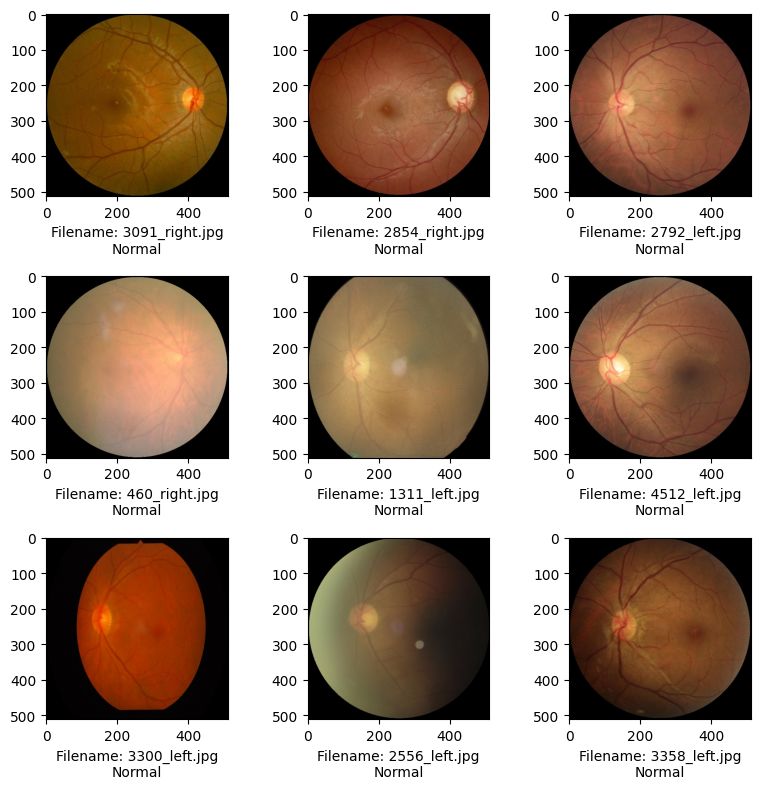

In [19]:
# create a grid for normal eyes

plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_random[i]
    image = cv2.imread(os.path.join(image_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_random[i]))

plt.tight_layout()

# Model Preperation

To prepare our data for modeling, we need to add category labels to the image lists. Previously, the objects df_norm_random and df_cat_all were converted into lists after appending columns. For convenience and further processing, we will convert these lists back into DataFrames.

Each image will be labeled as either 'normal' or 'cataract.' Since we plan to use an image data generator for training, which will handle one-hot encoding automatically, we can preserve the original string labels ('normal' and 'cataract') for better readability and interpretation.

In [20]:
df_cat_all = pd.DataFrame(df_cat_all, columns = ["filename"])

# add a new column of '1' to the dataframe
df_cat_all["label"] = "cataract"

df_cat_all.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [21]:
df_norm_random = pd.DataFrame(df_norm_random, columns = ["filename"])

# add a new column of '1' to the dataframe
df_norm_random["label"] = "normal"

df_norm_random.head()

,filename,label
0,3091_right.jpg,normal
1,2854_right.jpg,normal
2,2792_left.jpg,normal
3,460_right.jpg,normal
4,1311_left.jpg,normal


In [23]:
# now that we have both cataract and normal data, lets combine them into a single dataframe

df_combined = pd.concat([df_cat_all, df_norm_random], ignore_index=True)
df_combined


,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1139,2716_left.jpg,normal
1140,2956_right.jpg,normal
1141,4130_left.jpg,normal
1142,4076_left.jpg,normal


Before feeding the organized set of cataract and normal images into the model, we need to randomize the rows to ensure that training samples are selected randomly, promoting better generalization during model training.

When combining the datasets, appending them would result in the retention of the old index values, creating an additional column that we do not need. To avoid this, we will drop the old index entirely and allow the new DataFrame to generate a fresh, sequential index, ensuring a clean and randomized dataset for training.

In [24]:
# randomize rows of combined dataset for training

df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,2182_left.jpg,cataract
1,2135_left.jpg,cataract
2,2807_right.jpg,normal
3,2153_right.jpg,cataract
4,2212_right.jpg,cataract
...,...,...
1139,2683_left.jpg,normal
1140,3194_left.jpg,normal
1141,1144_right.jpg,cataract
1142,2975_right.jpg,normal


In [25]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, while the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1144
915
229


# Keras Preprocessing with Image Generator

Let's begin model training using Keras, a powerful deep learning framework that simplifies building, training, and deploying neural network models. With its user-friendly interface, Keras allows us to easily integrate CNNs, which are highly effective for image classification tasks.

We have prepared a well-structured dataframe, and with Keras's flow_from_dataframe functionality, we can efficiently generate augmented and scaled images directly from our dataset. Additionally, we will incorporate specific parameters to adjust the images, enhancing their variability and ensuring robust training. This combination of Keras and CNNs enables us to leverage advanced machine learning techniques with minimal effort.

In [26]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]
            )

# we need to rescale all of our images

test_datagen=ImageDataGenerator(rescale=1./255.)

In [27]:
# convert dataframe into string type

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)


In this step, we set up image data generators for the training, validation, and test datasets to preprocess and feed images into the model. The images are resized to a target size of 224x224 pixels, and labels are encoded in a categorical format for multi-class classification.

In [28]:
# create test, train and validation image data generators

img_size=224
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=image_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

# validation set is created from the training set,
# we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=image_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=image_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))


Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


# Image Generator Results

Let's examine the data produced by the image generator. Using the next command, we can extract the generated data, which is divided into two separate NumPy arrays: one containing the image data and the other containing the corresponding label data. This allows us to inspect the structure and content of the preprocessed data before feeding it into the model for training.

In [29]:
train_image_data, train_labels = next(train_generator)
train_image_data.shape

(32, 224, 224, 3)

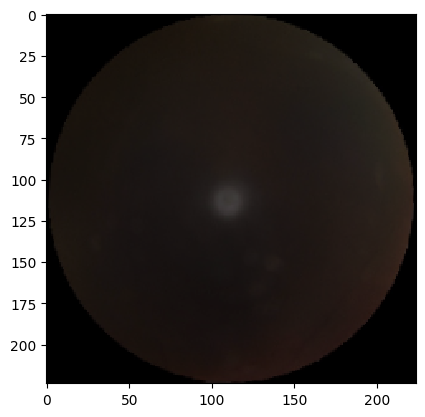

In [30]:
# lets take a look at a single augmented image

plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

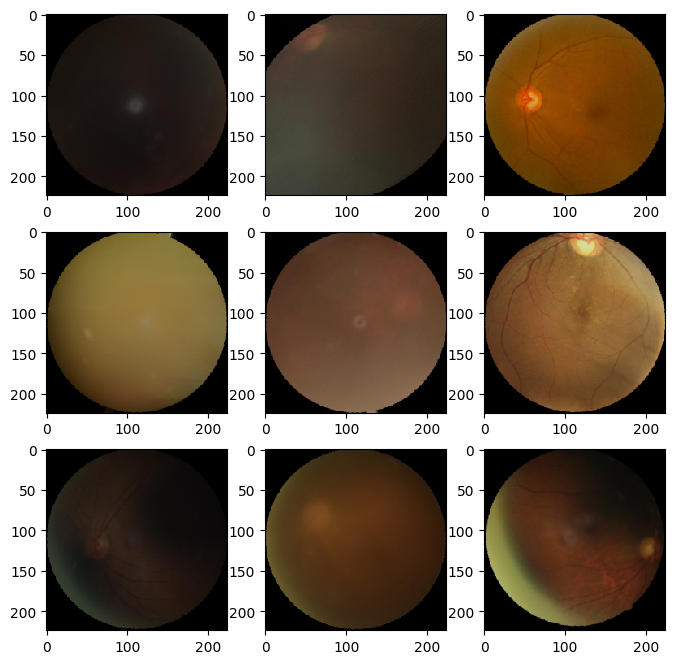

In [31]:
# lets make a grid of the data augmented images

plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_image_data[i], interpolation='nearest')

plt.show()

# Building Our Model

To build our transfer learning model, we utilize the VGG16 architecture, a popular and highly effective CNN model. Since we are tailoring the model to our custom dataset with two output classes, we exclude the fully connected top layers of VGG16 using the include_top=False option. This allows us to customize the final layers to suit our specific classification task.

We leverage the pretrained imagenet weights for the convolutional base, which provide robust feature extraction capabilities. These weights, trained on a large-scale dataset, are optimized to detect edges, corners, and rounded areas—features that are universally relevant across image datasets. Using these pretrained filters allows us to speed up the training process and benefit from proven, high-quality feature maps.

To prevent overfitting, we incorporate a dropout layer, dropping 50% of the perceptrons in the final dense layer. Additionally, we use the ADAM optimizer, an advanced gradient descent algorithm, to efficiently optimize our model during training.

In [32]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


For our model, we chose to implement both checkpointing and early stopping to enhance the training process and optimize model performance. A checkpoint allows us to monitor the model's accuracy during training and perform specific tasks when certain conditions are met. In this case, the checkpoint is configured to save the model as a file whenever it achieves its best validation accuracy, ensuring that the optimal version of the model is preserved.

Early stopping is used to monitor the model's accuracy over epochs based on a 'patience' parameter. If there is no improvement in accuracy within the specified number of consecutive epochs, the training process is automatically halted. This prevents unnecessary computation and reduces the risk of overfitting by stopping the training when further epochs are unlikely to yield significant performance gains. Together, these techniques ensure an efficient and effective training process while preserving the best-performing model for later use.

In [33]:
checkpoint = ModelCheckpoint(
    "vgg16_1.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)


early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto'
)


The steps_per_epoch parameter determines how many batches of samples are processed to complete one full epoch during model training. This value depends on the batch size, which is defined when initializing the training data.  

The total number of steps per epoch is typically calculated as the total number of samples in the training set divided by the batch size, ensuring all data is seen once per epoch. This parameter is essential for controlling the training process and aligning it with the size of your dataset and batch configuration.

In [34]:
batch_size = 32
n_spe = train_generator.samples // batch_size # steps per epoch
n_val_steps = valid_generator.samples // batch_size # number of validation steps
n_epochs = 30

print(n_spe,n_val_steps)

22 5


In [35]:
# train the model

hist = model.fit(
    train_generator,
    steps_per_epoch=n_spe,
    validation_data=valid_generator,
    validation_steps=n_val_steps,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[checkpoint, early]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5350 - loss: 2.2367
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to vgg16_1.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - accuracy: 0.5353 - loss: 2.2064 - val_accuracy: 0.8500 - val_loss: 0.5255
Epoch 2/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.7188 - loss: 0.6565

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.85000
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 523ms/step - accuracy: 0.7188 - loss: 0.6565 - val_accuracy: 0.6957 - val_loss: 0.6030
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6529 - loss: 0.6685
Epoch 3: val_accuracy did not improve from 0.85000
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 587ms/step - accuracy: 0.6538 - loss: 0.6676 - val_accuracy: 0.7750 - val_loss: 0.4669
Epoch 4/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8125 - loss: 0.5169
Epoch 4: val_accuracy did not improve from 0.85000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8125 - loss: 0.5169 - val_accuracy: 0.7391 - val_loss: 0.5232
Epoch 4: early stopping


In [36]:
# load saved model

model = load_model('./vgg16_1.keras')

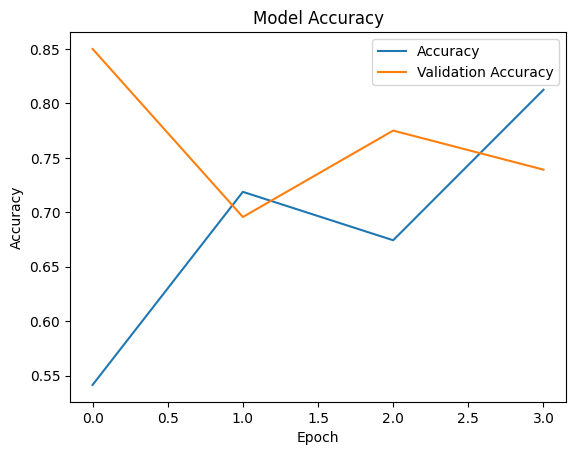

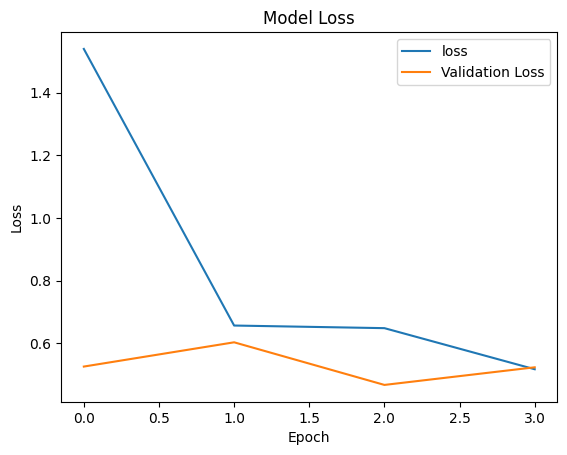

In [37]:
# plot accuracy vs loss

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

# Making Predicitions

Using predict_generator, we can generate predictions for our test dataset by feeding batches of image data into the model through a generator. Before making predictions, the test generator is reset to ensure that no leftover image data from previous iterations is carried over. The output of the predictions consists of categorical labels, where 0 represents "Cataract" and 1 represents "Normal." It is important to note that the predictions output numerical labels rather than image data, providing classification results for the test images

In [38]:
test_generator.reset()

In [39]:
steps = math.ceil(test_generator.samples / batch_size)

pred = model.predict(test_generator, verbose=1, steps=steps)


8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step


In [40]:
# convert the data into 1s and 0s for simple classification

predicted_class_idx=np.argmax(pred,axis=1)

#print the same 10 rows

print(predicted_class_idx[0:10])
print(len(predicted_class_idx))

[0 1 0 1 1 1 0 0 0 1]
229


In [43]:
# evaluate model's accuracy

model.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.8840 - loss: 0.4429


[0.4493650197982788, 0.8602620363235474]

In [44]:
# instead of 1s and 0s now, convert one-hot category labels to text labels

valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

Here, we use the training label string names, "Cataract" and "Normal," to convert the one-hot encoded predicted class labels back into their corresponding string names. These lines of code map the predicted numerical values to their respective category names and store them in the predicted_labels variable, ensuring the output is human-readable and aligned with the original label categories.

In [45]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]
pred_labels[1:10]


['normal',
 'cataract',
 'normal',
 'normal',
 'normal',
 'cataract',
 'cataract',
 'cataract',
 'normal']

In [46]:
# create a new dataframe with filename and prediction

filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,2135_left.jpg,cataract
1,2839_right.jpg,normal
2,2129_left.jpg,cataract
3,2636_left.jpg,normal
4,3023_left.jpg,normal


In [47]:
prediction_df.iloc[35]

,35
Filename,2128_right.jpg
Prediction,cataract


In [48]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2128_right.jpg
0


Now that we have verified that the test data and predictions are properly aligned, we can list all predictions and compare them to the actual test labels. This example is conducted using a small test dataset (fewer than 1,000 samples) for simplicity and clarity.

In [49]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict)

new_dict={}

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' )

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]

    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "


    print(f' {result}   {pred_class}    {true_class}      {file}')

{'cataract': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   cataract    cataract      2135_left.jpg
 Correct   normal    normal      2839_right.jpg
 Correct   cataract    cataract      2129_left.jpg
 Correct   normal    normal      2636_left.jpg
 Correct   normal    normal      3023_left.jpg
 Correct   normal    normal      884_right.jpg
 Wrong     cataract    normal      2698_left.jpg
 Correct   cataract    cataract      907_left.jpg
 Correct   cataract    cataract      2143_right.jpg
 Correct   normal    normal      2866_right.jpg
 Correct   cataract    cataract      2104_right.jpg
 Correct   cataract    cataract      2178_left.jpg
 Correct   normal    normal      2511_right.jpg
 Correct   normal    normal      2631_left.jpg
 Correct   normal    normal      2556_left.jpg
 Correct   cataract    cataract      2213_left.jpg
 Correct   normal    normal      2848_right.jpg
 Wrong     cataract    normal      2935_right.jpg
 Correct   cataract    cataract      

Here we retrieve a batch of test images and their corresponding labels from the test generator, then examine a specific sample by printing its filename, true label, and predicted label. It ensures the test data, labels, and predictions are correctly aligned for validation and debugging.

In [50]:
test_image_data, test_labels = next(test_generator)

print(test_image_data.shape)
print(test_labels.shape)

z = 0
test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

(32, 224, 224, 3)
(32, 2)
2135_left.jpg
0


'cataract'

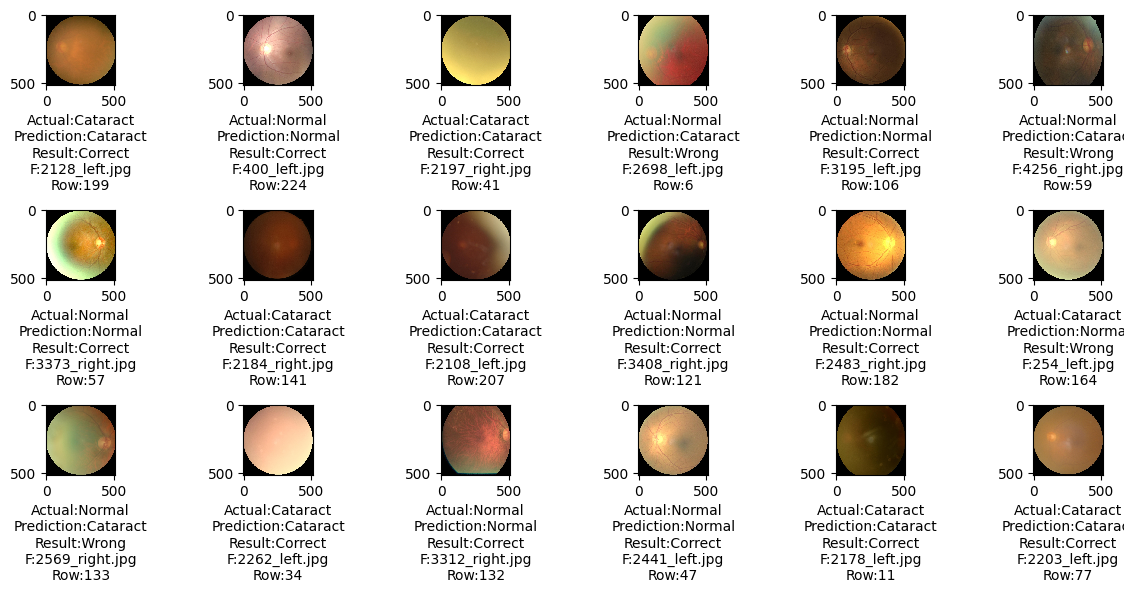

In [51]:
# plot our comparison grid

plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))

    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(image_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"


    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout()

# Classification Results

In [52]:
print('Classification Results')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Results
              precision    recall  f1-score   support

    Cataract       0.85      0.87      0.86       113
      Normal       0.87      0.85      0.86       116

    accuracy                           0.86       229
   macro avg       0.86      0.86      0.86       229
weighted avg       0.86      0.86      0.86       229



# Confusion matrix

In [53]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[98, 15],
       [17, 99]])

In [54]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['cataract','normal']

Confusion matrix, without normalization
[[98 15]
 [17 99]]


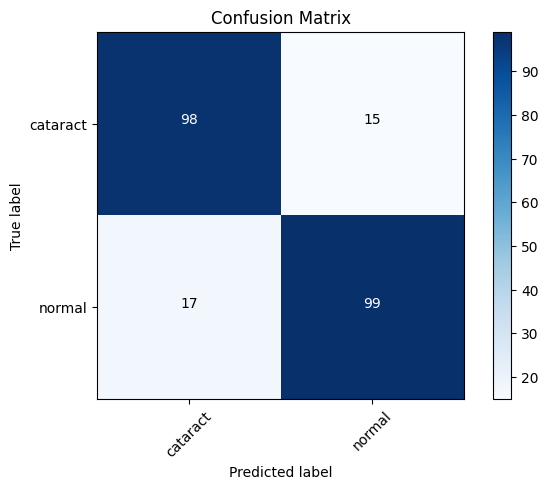

In [55]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')